In [1]:
import gym
import matplotlib
import numpy as np
from collections import defaultdict
import plotting

matplotlib.style.use('ggplot')

In [2]:
env=gym.make('Blackjack-v0')

In [3]:
def random_policy(observation, nA):
    A=np.ones(nA, dtype= float)/nA
    return A

In [4]:
def greedy_policy( observation, Q, epsilon, nA):
    
    A=np.ones(nA, dtype=float) * epsilon / nA
    best_action= np.argmax(Q[observation])
    A[best_action]+= (1- epsilon)
    return A

In [5]:
def mc_control_epsilon_greedy_importance_sampling(env, n_episodes, epsilon, discount_factor=1.0):
    
    returns_count=defaultdict(float)
    returns_sum=defaultdict(float)
    Q = defaultdict(lambda : np.zeros(env.action_space.n))
    final_policy = defaultdict(lambda : np.zeros(env.action_space.n))
    
    for i in range(n_episodes):
        
        state=env.reset()
        total_reward=0
        episode=[]
        importance_sampling_factor=1
        
        for index in range(20):
            behavior_policy = random_policy(state, env.action_space.n)
            action = np.random.choice(np.arange(len(behavior_policy)),p=behavior_policy)
            next_state, behavior_policy_reward, done, _ = env.step(action)
            episode.append((state,action,behavior_policy_reward))
            
            real_policy= greedy_policy(state, Q, epsilon, env.action_space.n)
            #importance_sampling_factor *= (real_policy[action]/behavior_policy[action])
            importance_sampling_factor *= (1/behavior_policy[action])
            #total_behavior_policy_reward += behavior_policy_reward * (discount_factor ** i) #**Mistake
            if done:
                break
            state = next_state
            
        #print(importance_sampling_factor)
        
        k=0
        for _state, _action, _reward in list(reversed(episode)):
            returns_count[(_state,_action)] +=1
            total_reward = total_reward * (discount_factor**k) + _reward
            returns_sum[(_state,_action)] += importance_sampling_factor *  (total_reward - returns_sum[(_state,_action)])/returns_count[(_state,_action)]
            
            Q[_state][_action]= returns_sum[(_state,_action)]
            
    for _state_ in Q:
        final_policy[state]= greedy_policy(_state_, Q, epsilon, env.action_space.n)
        
    return Q, final_policy                                                                    

In [6]:
Q, policy = mc_control_epsilon_greedy_importance_sampling(env,n_episodes=500000,epsilon=0.0)

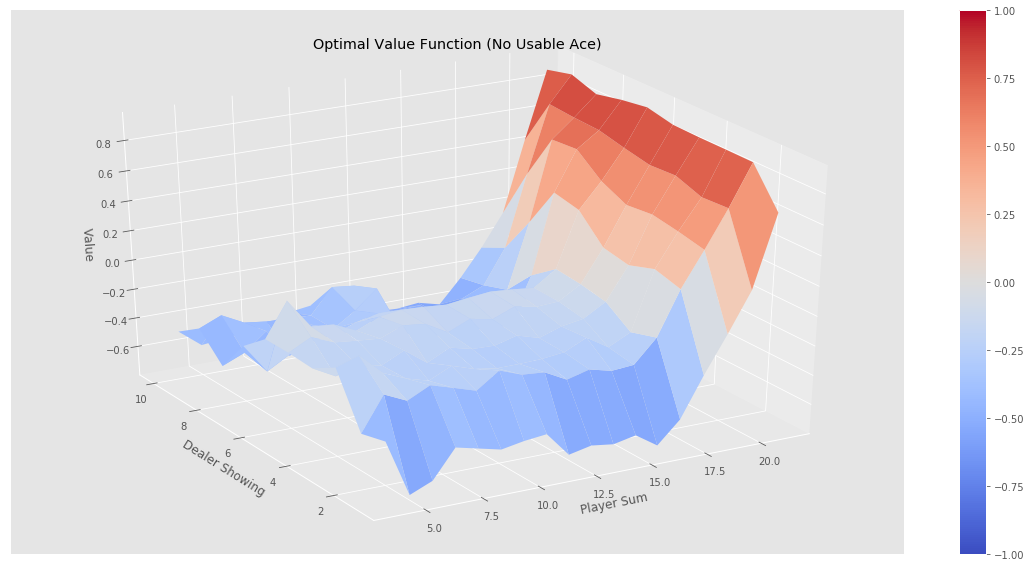

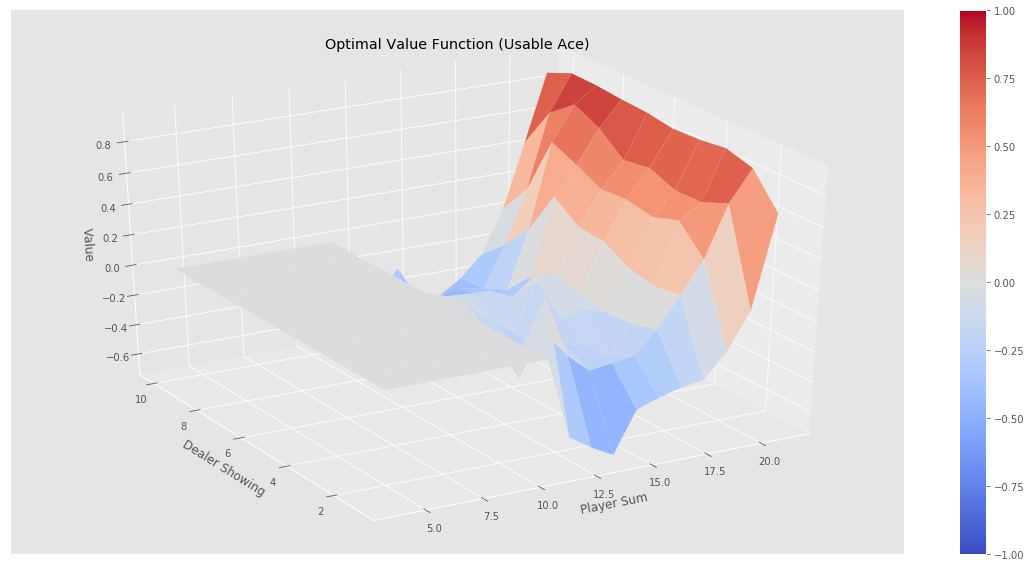

In [7]:
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

# Points to be noted regarding the code:

### 1) Regarding epsilon values:

The epsilon values need to be explored and data must be observed at every ends of varying epsilon.

### 2) Importance sampling factor:

I dont know the reason why importance sampling factor is multiplied with the whole error value instead of just multiplying with the totat behavior policy reward. If somebody knows the reason, they can ping me.